## Pre-MCMC calculations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import astropy
import scipy.integrate as integrate
import pandas
from astropy.cosmology import FlatLambdaCDM
from IPython.display import display, Math

In [2]:
# Importing constants 

Planck = astropy.cosmology.realizations.Planck18

T_CMB = Planck.Tcmb0  # Temperature of the CMB
H_0 = Planck.H0  # Current Hubble constant
Omega_m = Planck.Om0  # Matter density parameter
Omega_lambda = Planck.Ode0  # Dark energy density parameter
c = astropy.constants.c.to('km/s')  # Speed of light in km/s
sigma_T = astropy.constants.sigma_T.to('km2')  # Thomson scattering cross-section in km^2
Omega_b = Planck.Ob0  # Baryon density parameter


# Setting parameters

z = 8  # Redshift of the quasar bubbles 
f_H = 0.21  # fraction of neutral hydrogen at z = 8

In [3]:
# Input Data

data = pandas.read_csv('Data/u_0.0pc_noise.csv')

Ang_deg = np.array([data['radius_y'][1]])  # In arcmins
amp = np.array([data['amp_y'][1]]) * 1e-6  # Amplitude in K

In [4]:
# Importing the Flat Lambda CDM model

cosmo = FlatLambdaCDM(H0=H_0.value, Om0=Omega_m, Tcmb0= T_CMB.value)


# Obtaining the angular diameter distance at z

D_A = cosmo.angular_diameter_distance(z)  # units: Mpc/radian


# Defining a function that converts from our angular distance to proper distance

def AngToDist(Ang_deg= Ang_deg):
    
    Ang_rad = Ang_deg * np.pi / (180 * 60)  # Convert arcmins to radians
    Distance = D_A * Ang_rad  # Convert angular distance to actual distance

    return Distance


In [5]:
# Calculating the actual radii of the bubbles and y

Radius = AngToDist(Ang_deg)  # in Mpc

y = amp / T_CMB.value  

In [6]:
# Calculating n_e and n_H

n_e = y * 3 * np.sqrt(1+z) / (sigma_T * 0.001 * 2 * Radius.to('km'))

n_H = n_e / (1 - f_H)  # Assuming all electrons are from ionized hydrogen
n_H

<Quantity [6.90633258e+11] 1 / km3>

Alternative formula to calculate $n_H$: 

$$ \bar{n}_H = \frac{\rho_{crit}}{m_H} \cdot (1 - Y) \Omega_b \cdot (1 + z)^3 $$

where $ \rho_{crit} = \frac{3 H_0^2}{8 \pi G} $ and $ Y = 0.247 $ for our case.

In [43]:
# Alternate way to calculate n_H

n_H = ((3 * H_0**2)/(8 * np.pi * astropy.constants.G))/(astropy.constants.m_p) * (1 - 0.247) * (Omega_b) * (1 + 0)**3 * np.array([1])
n_H = f_H * n_H.to('km-3')  # Convert to km^-3
n_H

<Quantity [39809356.53392646] 1 / km3>

----

## MCMC Sampling

$$\tilde{\dot{N}} = {\dot{N}}/{10^{58}},  \tilde{t_Q} = t_Q/10^{7}$$  

$$ R = \left( \frac{3}{4 \pi n_H}\right)^{1/3} (1 + z)^{-1} (\tilde{\dot{N}} \tilde{t_Q})^{1/3} \cdot (10^{58})^{1/3} \cdot (10^7 \cdot 3.156 \times 10^7)^{1/3} $$

The last $3.156 \times 10^7$ is for converting years into seconds

In [33]:
# Defining the model using the Stromgren sphere approximation

def model(theta, n_H): 
    N_tilde, t_tilde = theta
    return (((3)/(4*np.pi*n_H))**(1/3)) * (1+z)**(-1) * (N_tilde * t_tilde)**(1/3) * (1e58)**(1/3) * (1e7 * 3.156e7)**(1/3)  

In [34]:
# Setting up initial, lower and upper bounds for the parameters

N_ini = 50  
N_min = 1   
N_max = 100

t_ini = 5
t_min = 0.1
t_max = 10

In [35]:
# Calculating error in the diameter

Ang_err = np.array([0.5] * len(Ang_deg))  # Error in determining the angular diameter in arcmins
Radius_err = Ang_err * np.pi / (180 * 60) * D_A  # Convert angular error to actual diameter error

In [36]:
# Defining the log-likelihood function

def lnlike(theta, x, y, y_err):
    return -0.5 * np.sum(((y - model(theta, x)) / y_err) ** 2)

# Defining the log-prior function

def lnprior(theta):
    N_tilde, t_tilde = theta
    if N_tilde < N_min or t_tilde < t_min or N_tilde > N_max  or t_tilde > t_max:
        return -np.inf
    return 0.0

# Defining the log-posterior function

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


In [37]:
# Setting initial values for the parameters
initial = [N_ini, t_ini]  

# Setting up the MCMC sampler
ndim = len(initial)
nwalkers = 7 * ndim    # Preferentially 3-5 times the number of dimensions (minimum 2 times the number of dimensions)
n_burn = 200
n_steps = 10000

# Initializing the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(n_H.to('km-3').value, Radius.to('km').value, Radius_err.to('km').value))

# Adding little variation to the initial positions
p0 = []
for i in range(nwalkers):
    pos = [N_ini, t_ini]  # Start with the initial values
    pos[0] = pos[0] + 1e-4 * pos[0] * np.random.random(1)[0]  # Adding a small random variation to N_dot
    pos[1] = pos[1] + 1e-4 * pos[1] * np.random.random(1)[0]  # Adding a small random variation to t_Q
    p0.append(pos)   


In [38]:
# Running the MCMC sampler

# Burn-in phase
print("Running burn-in phase...")
sampler.reset()
state = sampler.run_mcmc(p0, n_burn, progress=True)
sampler.reset()

# Main sampling phase
print("Running main sampling phase...")
pos, prob, state = sampler.run_mcmc(state, n_steps, progress=True)

# Extracting the samples
samples = sampler.get_chain(flat=True)      # Flatten the chain to get all samples in a single array


Running burn-in phase...


100%|██████████| 200/200 [00:00<00:00, 1406.04it/s]


Running main sampling phase...


100%|██████████| 10000/10000 [00:05<00:00, 1901.71it/s]


In [39]:
# Calculating the radii using the estimated parameters 

med_params = np.median(samples, axis=0)  # The median of the parameters 
print(model(med_params, n_H).to('Mpc'))  # The estimated radius in Mpc

[11.2295479] Mpc


In [40]:
print("N_tilde:", med_params[0], "; t_tilde:", med_params[1])

mcmc = np.percentile(samples[:, 0], [16, 50, 84], axis=0)
q = np.diff(mcmc)
print("N_tilde_err: -", q[0], "to +", q[1])

mcmc = np.percentile(samples[:, 1], [16, 50, 84], axis=0)
q = np.diff(mcmc)
print("t_tilde_err: -", q[0], "to +", q[1])

N_tilde: 5.3742411148393865 ; t_tilde: 1.4199279575164478
N_tilde_err: - 3.615139170159011 to + 19.973317277268805
t_tilde_err: - 1.1174077197639003 to + 2.921112406778998


In [41]:
# The radius values
Radius

<Quantity [11.23316626] Mpc>

In [42]:
sampler.acceptance_fraction

array([0.2157, 0.2116, 0.2319, 0.2345, 0.1901, 0.2046, 0.2124, 0.1941,
       0.1766, 0.1941, 0.1588, 0.2229, 0.1571, 0.2318])

In [18]:
# Sorting the n_H and Radius arrays based on n_H for better visualization

order = np.argsort(n_H)
n_H_ordered = n_H[order]
Radius_ordered = Radius[order]

model_ordered = model(med_params, n_H_ordered).to('Mpc')

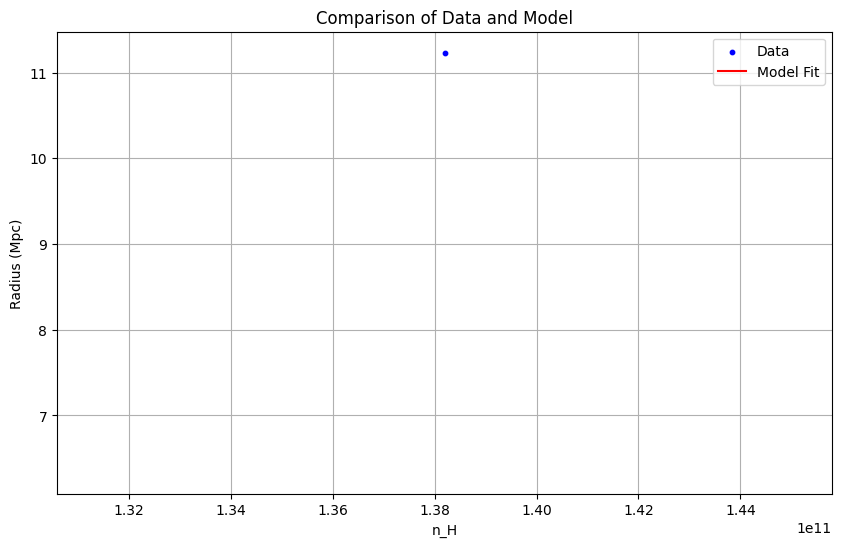

In [19]:
# Plotting the results 

plt.figure(figsize=(10, 6))
plt.scatter(n_H, Radius, label='Data', color='blue', s=10)
plt.plot(n_H_ordered, model(med_params, n_H_ordered).to('Mpc'), label='Model Fit', color='red')
plt.xlabel('n_H')
plt.ylabel('Radius (Mpc)')
plt.title('Comparison of Data and Model')
plt.legend()
plt.grid()
plt.show()


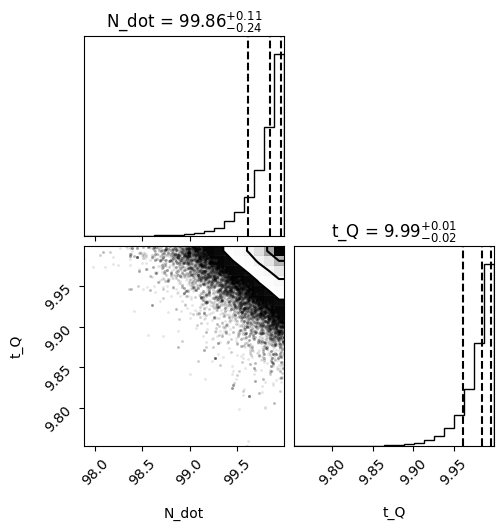

In [20]:
# Plotting a corner plot of the samples along with the quantiles

fig = corner.corner(samples, labels=["N_dot", "t_Q"],  quantiles=[0.16, 0.5, 0.84], show_titles=True, plot_datapoints=True)

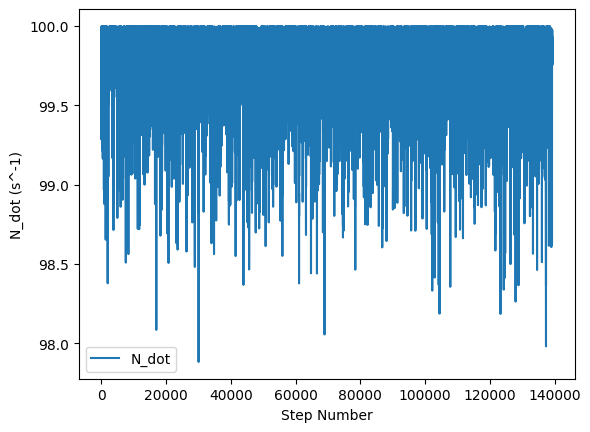

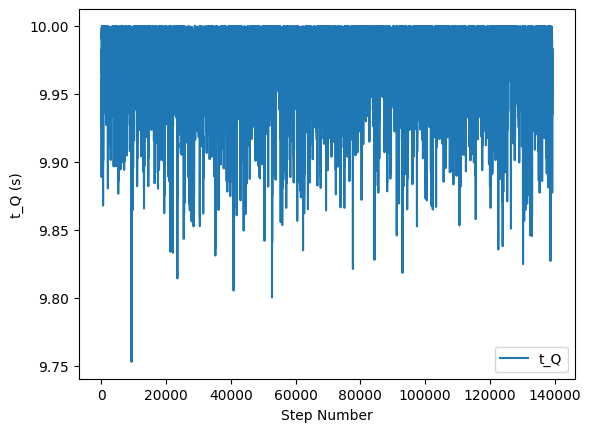

In [21]:
# Plotting the variation with time of the MCMC walkers

chains = sampler.chain[:, 50:, :].reshape((-1, ndim))

plt.plot(np.arange(len(chains[:, 0])), chains[:, 0], label='N_dot')
plt.xlabel('Step Number')
plt.ylabel('N_dot (s^-1)')
plt.legend()
plt.show()

plt.plot(np.arange(len(chains[:, 1])), chains[:, 1], label='t_Q')
plt.xlabel('Step Number')
plt.ylabel('t_Q (s)')
plt.legend()
plt.show()
plt.show()